In [444]:
import pandas as pd
import numpy as np

In [445]:
order = 50
states = 100
outputStates = 2
lookAhead = order-1
outputOrder = 7*2
lastPredictionAdj = lookAhead + outputOrder






In [446]:
def jsonToDataFrame(stockData):
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []
    dates = []

    for key in stockData:
        (open_, high, low, close, volume) = stockData[key]
        opens.append(open_)
        highs.append(high)
        lows.append(low)
        closes.append(close)
        volumes.append(volume)
        dates.append(key)

    data = {'Date':dates, 'Open':opens, 'High':highs, 'Low':lows, 'Close':closes, 'Volume': volumes}

    return pd.DataFrame(data=data)

In [447]:



def convertArrayToTimeSeries(array, duration):
    length = len(array) - duration
    if(length <= 0):
        return np.ndarray((0,duration))

    subTimeSeries = np.ndarray((length, duration))
    for i in range(0, length):
        subTimeSeries[i] = array[i:i+duration]
    return subTimeSeries

def normalizeTimeSerie(timeSerie):
    avg = np.mean(timeSerie)
    var = np.var(timeSerie)
    if(var == 0):
        return np.zeros(timeSerie.shape)
    else:
        return (timeSerie - avg)/var

def normalizeTimeSeries(timeSeries):
    avg = np.mean(timeSeries, axis=1)
    var = np.var(timeSeries, axis=1)
    

    timeSeriesNorm = np.ndarray(timeSeries.shape)
    for i in range(len(timeSeries)):
        if(var[i] == 0):
            timeSeriesNorm[i] = np.zeros(timeSeries[i].shape)
        else:
            timeSeriesNorm[i] = (timeSeries[i] - avg[i])/var[i]
            #maxNorm = np.max(timeSeriesNorm[i])
            #minNorm = np.min(timeSeriesNorm[i])
            #timeSeriesNorm[i] = (timeSeriesNorm[i]-minNorm)/(maxNorm-minNorm)


    return timeSeriesNorm




In [448]:
from convertStockToJson import getJsonDataFromFile

def combineStockData(stockDatadf):
    closes = stockDatadf['Close']
    opens = stockDatadf['Open']
    combined = np.zeros(len(closes)+len(opens))
    
    i = 0
    for (open_, close_) in zip(opens, closes):
        combined[i] = open_
        combined[i+1] = close_
        i += 2

    return combined


def loadTimeSeriesNormalized(name, inputDuration, outputDuration):
    stockData = getJsonDataFromFile(name)
    stockDatadf = jsonToDataFrame(stockData) 
    combined = combineStockData(stockDatadf)
    inputTimeSeries = convertArrayToTimeSeries(combined, inputDuration)
    outputTimeSeries = convertArrayToTimeSeries(combined, outputDuration)
    inputTimeSeriesNorm = normalizeTimeSeries(inputTimeSeries)
    outputTimeSeriesNorm = normalizeTimeSeries(outputTimeSeries)

    return (inputTimeSeriesNorm, outputTimeSeriesNorm, inputTimeSeries, outputTimeSeries, stockDatadf)

In [449]:
def loadTimeSeriesNormalizedMultiple(names, inputDuration, outputDuration):
    closes = []
    for name in names:
        stockData = getJsonDataFromFile(name)
        stockDatadf = jsonToDataFrame(stockData) 
        combined = combineStockData(stockDatadf)
        closes.extend(combined)
        inputTimeSeries = convertArrayToTimeSeries(closes, inputDuration)
        outputTimeSeries = convertArrayToTimeSeries(closes, outputDuration)
        inputTimeSeriesNorm = normalizeTimeSeries(inputTimeSeries)
        outputTimeSeriesNorm = normalizeTimeSeries(outputTimeSeries)

    return (inputTimeSeriesNorm, outputTimeSeriesNorm, inputTimeSeries, outputTimeSeries, stockDatadf)

In [450]:
from sklearn.cluster import KMeans
import numpy as np
import numpy as np
import matplotlib.pyplot as plt


stockNameTrainedOn = 'QAN'
stockNameTrainedOns = ['QAN'] #, 'IOO', 'ANZ','NAB','TLS','QAN']
subTimeSeriesNormsBIG = []
subTimeSeriesNorms = []
outputTimeSeriesNorms = []

for name in stockNameTrainedOns:
    (subTimeSeriesNorm, outputTimeSeriesNorm, subTimeSeries, outputTimeSeries, stockDatadf) =       loadTimeSeriesNormalized(name, order, outputOrder)
    subTimeSeriesNormsBIG.extend(subTimeSeriesNorm)
    subTimeSeriesNorms.append(subTimeSeriesNorm)
    outputTimeSeriesNorms.append(outputTimeSeriesNorm)


print(len(subTimeSeriesNormsBIG))


kmeans = KMeans(n_clusters=states, random_state=0).fit(subTimeSeriesNormsBIG)
cluserCenters = kmeans.cluster_centers_

# for cluster in cluserCenters:
#     plt.plot(cluster)
#     plt.show()






3474


In [451]:
maxChange = max(-np.min(cluserCenters), np.max(cluserCenters))
increaseData = np.linspace(-maxChange, maxChange, outputOrder)
mid = np.zeros(outputOrder)
decreaceData = np.linspace(maxChange, -maxChange, outputOrder)

dummyData = np.array([increaseData, decreaceData])


outputKMeans = KMeans(n_clusters=outputStates, random_state=0).fit(dummyData)
outputKMeans.cluster_centers_



array([[-271.10849687, -229.39949735, -187.69049783, -145.98149832,
        -104.2724988 ,  -62.56349928,  -20.85449976,   20.85449976,
          62.56349928,  104.2724988 ,  145.98149832,  187.69049783,
         229.39949735,  271.10849687],
       [ 271.10849687,  229.39949735,  187.69049783,  145.98149832,
         104.2724988 ,   62.56349928,   20.85449976,  -20.85449976,
         -62.56349928, -104.2724988 , -145.98149832, -187.69049783,
        -229.39949735, -271.10849687]])

In [452]:
outputsTransform = outputKMeans.transform(outputTimeSeriesNorm).transpose()
minOutPutTransform = np.min(outputsTransform, axis=1)
maxOutPutTransform = np.max(outputsTransform, axis=1)
print(minOutPutTransform)
print(maxOutPutTransform)

[390.37870449 348.74990835]
[1074.02673862 1213.90342622]


In [453]:

buysOrSells = np.zeros(outputStates) 
buysOrSells[0] = 1
buysOrSells[1] = -1
# buysOrSells[2] = 0

In [454]:
def predictStateVector(timeSerieNorm, kmeans):
    if len(kmeans.cluster_centers_) == outputStates:
        distances = kmeans.transform([timeSerieNorm])[0]
        return 1-(distances-minOutPutTransform)/(maxOutPutTransform-minOutPutTransform)
    else:
        distances = kmeans.transform([timeSerieNorm])[0]
        minDis = np.min(distances)
        maxDis = np.max(distances)
        distances -= minDis
        distances /= maxDis
        distances = 1 - distances
        distances = distances * distances * distances
        return distances


def predictStatesVector(timeSerieNorms, kmeans):
    result = np.zeros((timeSerieNorms.shape[0], len(kmeans.cluster_centers_)))
    for i in range(len(timeSerieNorms)):
        result[i] = predictStateVector(timeSerieNorms[i], kmeans)
    return result

    distances = kmeans.transform(timeSerieNorms)
    minDis = np.min(distances, axis=1)
    maxDis = np.max(distances, axis=1)
    for i in range(len(distances)):
        distances[i] -= minDis[i]
        distances[i] /= maxDis[i]
        distances[i] = 1 - distances[i]
        distances[i] = distances[i] * distances[i] * distances[i]
    return distances

def valuateOuput(timeSerieNorms):
    value = np.zeros(len(timeSerieNorms))
    for i in range(len(timeSerieNorms)):
        value[i] = timeSerieNorms[i][-1] - timeSerieNorms[i][0]
        
    return value

    

In [455]:
transitionProbabilities = np.zeros((states, outputStates))

transitionCounts = np.zeros((states, outputStates))

transitionStateCounts = np.zeros(states)


def trainMarkokChain(timeSeriesNormalized, outTSNorm):
    global transitionCounts, transitionStateCounts, transitionProbabilities

    subSeriesClassifified = kmeans.predict(subTimeSeriesNorm)
    outSeriesClassified = outputKMeans.predict(outTSNorm)

    for i in range(len(subSeriesClassifified)-lookAhead):
        currentState = subSeriesClassifified[i]
        nextState = outSeriesClassified[i+lookAhead]
        
        transitionCounts[currentState, nextState] += 1
        transitionStateCounts[currentState] += 1

def trainMarkokChainContinous(timeSeriesNormalized, outTSNorm):
    global transitionCounts, transitionStateCounts, transitionProbabilities
   
    transitionProbabilities = np.zeros(transitionProbabilities.shape)
    transitionCounts = np.zeros(transitionCounts.shape)
    transitionStateCounts = np.zeros(transitionStateCounts.shape)

    timeSeriesKMeanDistances = predictStatesVector(timeSeriesNormalized, kmeans)
    outputTSKMeanDistances = predictStatesVector(outTSNorm, outputKMeans)



    transitionCountsT = transitionCounts.transpose()
    for i in range(len(timeSeriesKMeanDistances)-lookAhead):
        currentState = timeSeriesKMeanDistances[i]
        nextState = outputTSKMeanDistances[i+lookAhead]
        for i in range(len(nextState)):
            adjust = currentState * nextState[i]
            transitionCountsT[i] += adjust
    transitionCounts = transitionCountsT.transpose()
        
    transitionStateCounts = np.sum(transitionCounts, axis=1)

def trainMarkokChainContinousAlt(timeSeriesNormalized, outTSNorm):
    global transitionCounts, transitionStateCounts, transitionProbabilities
   
    transitionProbabilities = np.zeros(transitionProbabilities.shape)
    transitionCounts = np.zeros(transitionCounts.shape)
    transitionStateCounts = np.zeros(transitionStateCounts.shape)

    timeSeriesKMeanDistances = predictStatesVector(timeSeriesNormalized, kmeans)

    for i in range(len(timeSeriesKMeanDistances)-lookAhead):
        currentState = timeSeriesKMeanDistances[i]
        tsNorm = outTSNorm[i+lookAhead]
        dif = tsNorm[-1] - tsNorm[0]
        if(dif > 0):
            for j in range(len(currentState)):
                transitionCounts[j][0] += currentState[j] * dif
        else:
            for j in range(len(currentState)):
                transitionCounts[j][1] += currentState[j] * -dif
      
        
        
    transitionStateCounts = np.sum(transitionCounts, axis=1)

def trainMarkokChainContinousAltAlt(timeSeriesNormalized, outTSNorm):
    global transitionCounts, transitionStateCounts, transitionProbabilities
   
    transitionProbabilities = np.zeros(transitionProbabilities.shape)
    transitionCounts = np.zeros(transitionCounts.shape)
    transitionStateCounts = np.zeros(transitionStateCounts.shape)

    timeSeriesKMeanDistances = predictStatesVector(timeSeriesNormalized, kmeans)

    for i in range(len(timeSeriesKMeanDistances)-lookAhead):
        currentState = timeSeriesKMeanDistances[i]
        tsNorm = outTSNorm[i+lookAhead]
        dif = np.sum(tsNorm - tsNorm[0])/len(tsNorm)
        if(dif > 0):
            for j in range(len(currentState)):
                transitionCounts[j][0] += currentState[j] * dif
        else:
            for j in range(len(currentState)):
                transitionCounts[j][1] += currentState[j] * -dif
      
        
        
    transitionStateCounts = np.sum(transitionCounts, axis=1)


for (subTimeSeriesNorm, outputTimeSeriesNorm) in zip(subTimeSeriesNorms, outputTimeSeriesNorms):
    #trainMarkokChain(subTimeSeriesNorm, outputTimeSeriesNorm)
    #trainMarkokChainContinous(subTimeSeriesNorm, outputTimeSeriesNorm)
    #trainMarkokChainContinousAlt(subTimeSeriesNorm, outputTimeSeriesNorm)
    trainMarkokChainContinousAltAlt(subTimeSeriesNorm, outputTimeSeriesNorm)

print(transitionCounts)

[[21864.24436996 19694.98920397]
 [34299.10389727 29876.35515807]
 [40037.19405541 34124.98167887]
 [28400.46220358 23706.9784349 ]
 [   41.09847675   102.76999784]
 [24059.40905449 21381.49169913]
 [30640.91064589 27042.56595685]
 [28958.3422265  24818.38958163]
 [  806.81432627   775.86701253]
 [13348.13724981 11806.89132184]
 [23956.48353582 19348.97888143]
 [37042.47020188 32431.34883428]
 [37941.06374755 32948.89433771]
 [36507.90272249 31958.10410863]
 [10017.3751438   9268.06016931]
 [   46.32409449    90.32041704]
 [39652.89276224 34150.61037411]
 [36528.59496371 31554.48736045]
 [32792.6924581  27869.01890757]
 [  111.06257073   151.92745871]
 [  495.62733211   508.88241808]
 [14173.50755866 12800.92744613]
 [34616.56225471 29147.28399182]
 [29329.08161869 24263.69234954]
 [18357.40689755 14491.79597106]
 [   53.37741502    96.37086326]
 [ 3895.26950702  3303.20840928]
 [ 8921.32392651  7427.6803767 ]
 [ 5543.02773279  4901.00558026]
 [ 1913.63651281  1795.68081155]
 [ 7861.76

In [456]:
def updateProbabilities():
    for i in range(transitionProbabilities.shape[0]):
        if(transitionStateCounts[i] != 0):
            for j in range(transitionProbabilities.shape[1]):
                transitionProbabilities[i, j] = transitionCounts[i, j]/transitionStateCounts[i]

updateProbabilities()
print(transitionProbabilities)

[[0.52609835 0.47390165]
 [0.53445826 0.46554174]
 [0.53986003 0.46013997]
 [0.5450366  0.4549634 ]
 [0.28566701 0.71433299]
 [0.52946594 0.47053406]
 [0.53119043 0.46880957]
 [0.53849204 0.46150796]
 [0.50977686 0.49022314]
 [0.53063495 0.46936505]
 [0.55319773 0.44680227]
 [0.53318604 0.46681396]
 [0.5352107  0.4647893 ]
 [0.5332267  0.4667733 ]
 [0.51942697 0.48057303]
 [0.33901175 0.66098825]
 [0.53727657 0.46272343]
 [0.53652969 0.46347031]
 [0.54058304 0.45941696]
 [0.42230715 0.57769285]
 [0.49340221 0.50659779]
 [0.52544224 0.47455776]
 [0.54288699 0.45711301]
 [0.54725814 0.45274186]
 [0.55883873 0.44116127]
 [0.3564476  0.6435524 ]
 [0.54112405 0.45887595]
 [0.54567995 0.45432005]
 [0.53073631 0.46926369]
 [0.51589992 0.48410008]
 [0.5559988  0.4440012 ]
 [0.53608168 0.46391832]
 [0.54070136 0.45929864]
 [0.38414404 0.61585596]
 [0.52758494 0.47241506]
 [0.54579107 0.45420893]
 [0.53125916 0.46874084]
 [0.51541954 0.48458046]
 [0.54529162 0.45470838]
 [0.54136039 0.45863961]


def loadTimeSeriesClassified(name, inputDuration, outputDuration):
    normalized = loadTimeSeriesNormalized(name, inputDuration, outputDuration)
    return (normalized, True)
    if(normalized.shape[0] > 0):
        return (kmeans.predict(normalized), True)
    else:
        return (None, False)

def testMarkovChain(subSeriesClassifified, outTSNorm):
    numCorrect = 0
    length = len(subSeriesClassifified)-lookAhead
    for i in range(length):
        currentState = subSeriesClassifified[i]
        nextStateCorrect = outTSNorm[i+lookAhead]
        nextStatePredict = np.argmax(transitionStateCounts[currentState])
        if(nextStatePredict == nextStateCorrect):
            numCorrect += 1
    if(length > 0):
        return numCorrect/length
    else:
        return None

from filesInPath import filesInPath

filenames = filesInPath('data')
import random

# random.shuffle(filenames)
# filenames = filenames[:40]
filenames = ['VAS', 'IOO', 'XRO', 'ANZ']

for (fileName,i) in zip(filenames, range(len(filenames))):
    #fileName = fileName[:-5]
 
    ((inputTS, outPutTs), success) = loadTimeSeriesClassified(fileName, order, outputOrder)  
    if(success):  
        percetage = testMarkovChain(inputTS, outPutTs)  
        if(percetage != None):
            print(fileName + ",  " + str(percetage * 100 ) + "%")


In [468]:

def shouldBuyorSells(timeSeries):
    timeSerieNorms = normalizeTimeSeries(timeSeries)
    rankings = predictStatesVector(timeSerieNorms, kmeans)
    return np.dot(rankings, np.dot(transitionProbabilities, buysOrSells))



def shoudlBuyorSell(timeSerie):
    distinct = False
    if distinct :
        currentState = kmeans.predict(normalizeTimeSeries(np.array([timeSerie])))[0]
        nextState = np.argmax(transitionProbabilities[currentState])
        return buysOrSells[nextState]
    else:
        #currentState = kmeans.predict(normalizeTimeSeries(np.array([timeSerie])))[0]
        timeSerieNorm = normalizeTimeSeries(np.array([timeSerie]))[0]
        rankings = predictStateVector(timeSerieNorm, kmeans)
        return np.dot(rankings, np.dot(transitionProbabilities, buysOrSells) )
        #return np.dot(transitionProbabilities, buysOrSells)[np.argmax(rankings)]


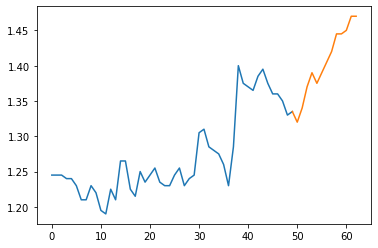

3.855963908945845
[[553.40975446 705.17310514]]
[0.7615278  0.58802318]


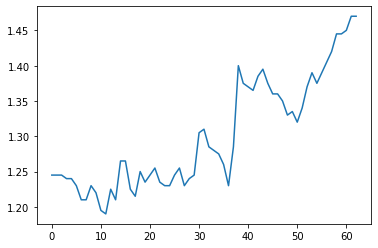

In [469]:
def plotSample():
    (subTimeSeriesNorm, outputTimeSeriesNorm, subTimeSeries, outputTimeSeries, stockDatadf) = loadTimeSeriesNormalized(stockNameTrainedOn, order, outputOrder)
    i = 295
    sample = subTimeSeries[i]
    sampleNorm = subTimeSeriesNorm[i]
    answer = outputTimeSeries[i+lookAhead]
    answerNorm = outputTimeSeriesNorm[i+lookAhead]
    plt.plot(np.arange(len(sample)),sample)
    plt.plot(np.arange(lookAhead, lookAhead+len(answer)),answer)
    plt.show()
    print(shoudlBuyorSell(sample))
   #print(outputKMeans.predit([normalizeTimeSerie(answer)]))
    print(outputKMeans.transform([answerNorm]))
    print(predictStateVector(answerNorm, outputKMeans))

    combined = combineStockData(stockDatadf)
    plt.plot(combined[i:i+lookAhead+outputOrder])
    plt.show()
plotSample()

In [470]:
def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False
        
        if(daysShouldWaitToSell == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    daysShouldWaitToSell = outputOrder
                    didBuy = True


        elif(daysShouldWaitToSell == 0):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                daysShouldWaitToSell = None
                didSell = True
        else:
            daysShouldWaitToSell -= 1
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower


def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None
    boughtFor = None
    stopGain = 0.05
    stopLoss = -0.03

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False

        profitLoss =  (stockPosition/boughtFor)-1 if boughtFor!=None else None

        
        if(boughtFor == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    didBuy = True
                    boughtFor = cost


        elif(profitLoss > stopGain or profitLoss < stopLoss):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                boughtFor = None
                didSell = True
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower


def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None
    boughtFor = None
    stopGain = 0.05
    stopLoss = -0.03
    sellThreshold = 0.12

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False

        profitLoss =  (stockPosition/boughtFor) - 1 if boughtFor!=None else None
        
        if(boughtFor == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    didBuy = True
                    boughtFor = cost


        elif(profitLoss > stopGain or profitLoss < stopLoss or sellThreshold > signal):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                boughtFor = None
                didSell = True
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower

In [471]:
def thresholdRange(subTimeSeries, steps = 20):
    signals = np.ndarray((len(subTimeSeries)))
   
    for i in range(len(subTimeSeries)):
        signals[i] = shoudlBuyorSell(subTimeSeries[i])
    
    minSig = np.min(signals)
    maxSig = np.max(signals)
    print(minSig)
    print(maxSig)
    if(minSig == maxSig):
        return [minSig]
    else:
        return np.arange(minSig, maxSig, (maxSig-minSig)/steps)



In [472]:

stockPriceHistory = combineStockData(jsonToDataFrame(getJsonDataFromFile('QAN')))
subTimeSeries = convertArrayToTimeSeries(stockPriceHistory, order)[-365*2:]

In [473]:
len(subTimeSeries)

730

In [474]:


bestthreshold = -np.inf
bestPrice = -np.inf
print(thresholdRange(subTimeSeries))
for threshold in thresholdRange(subTimeSeries):
    price = runModelAgainst(subTimeSeries, threshold)
    if(bestPrice < price):
        bestPrice = price
        bestthreshold = threshold
    print((price, threshold))

3.3338333688280453
4.582784846658881
[3.33383337 3.39628094 3.45872852 3.52117609 3.58362366 3.64607124
 3.70851881 3.77096639 3.83341396 3.89586153 3.95830911 4.02075668
 4.08320426 4.14565183 4.2080994  4.27054698 4.33299455 4.39544212
 4.4578897  4.52033727]
3.3338333688280453
4.582784846658881
(879.0299999999999, 3.3338333688280453)
(1154.8800000000008, 3.3962809427195872)
(1024.4000000000005, 3.4587285166111292)
(954.1100000000002, 3.521176090502671)
(1030.1499999999996, 3.583623664394213)
(1167.0100000000002, 3.646071238285755)
(1180.4300000000005, 3.708518812177297)
(1114.4300000000007, 3.770966386068839)
(1089.9599999999998, 3.833413959960381)
(1118.0500000000002, 3.895861533851923)
(1074.7499999999998, 3.958309107743465)
(929.4899999999999, 4.020756681635007)
(889.0699999999998, 4.0832042555265495)
(908.9, 4.145651829418091)
(895.42, 4.2080994033096335)
(900.18, 4.270546977201175)
(948.9, 4.3329945510927175)
(948.9, 4.395442124984259)
(948.9, 4.457889698875801)
(951.49, 4.5203

In [475]:

def trackModel(threshold):
    equity = np.zeros(len(subTimeSeries))
    monies = np.zeros(len(subTimeSeries))
    stockOverTime = np.zeros(len(subTimeSeries))
    buys = []
    hasBuys = [False]
    sells = []
    hasSells = [False]
    stockPrices = []
    signals = []
    def record(state):
        (i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal) = state
        buys.append(stockPrice if didBuy else None)
        sells.append(stockPrice if didSell else None)
        if(didBuy):
            hasBuys[0] = True
        if(didSell):
            hasSells[0] = True
        stockPrices.append(stockPrice)
        signals.append(signal)
        equity[i] = buyingPower + stocks*stockPrice
        monies[i] = buyingPower
        stockOverTime[i] = stocks*stockPrice

    runModelAgainst(subTimeSeries, threshold, record)

    plt.plot(equity)
    plt.xlabel('Time (days)')
    plt.ylabel('Equity ($)')
    plt.show()

    plt.plot(monies, c='blue')
    plt.plot(stockOverTime, c='red')
    plt.show()

    fig,ax = plt.subplots()
    ax.plot(stockPrices)
    ax.set_ylabel("Stock Price ($)")
    ax.set_xlabel("Time (days)")
    if(hasBuys[0]):
        ax.scatter(np.arange(len(buys)), buys, c='green')
    if(hasSells[0]):
        ax.scatter(np.arange(len(sells)), sells, c='red')
    ax2=ax.twinx()
    ax2.plot(signals,c='black', alpha=0.2)
    ax2.plot([0, len(signals)-1], [threshold, threshold], c='red', alpha=0.2)
    ax2.set_ylabel('Signal, Future Prediction')
    fig.show()
    plt.show()

    plt.plot(signals)
    plt.show()

3.3338333688280453
4.582784846658881
4.3746262670204095


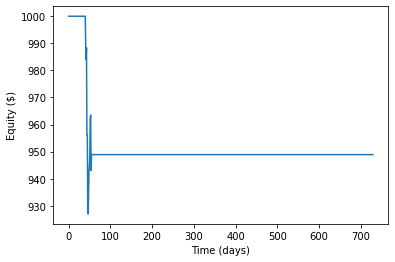

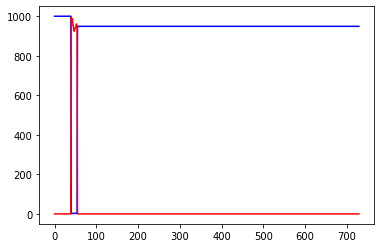

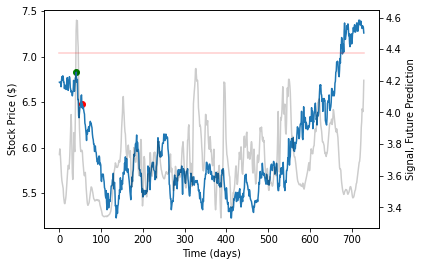

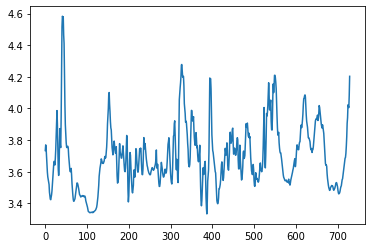

4.166467687381937


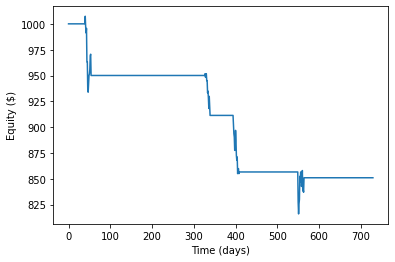

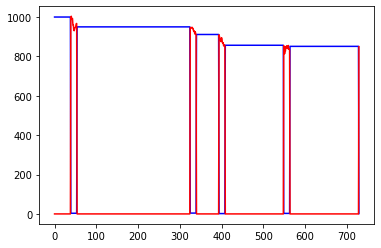

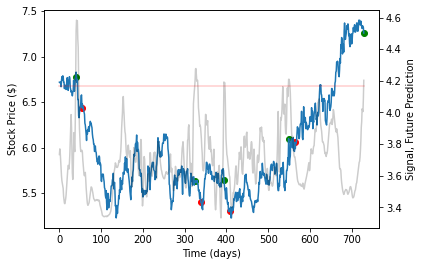

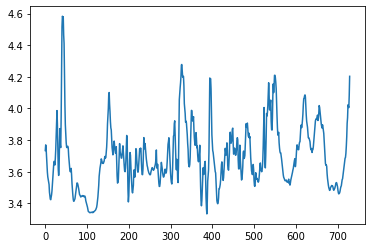

3.958309107743464


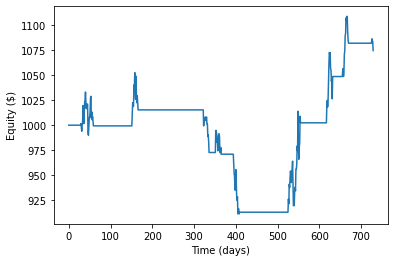

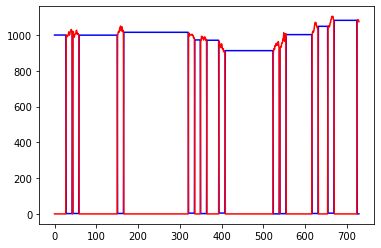

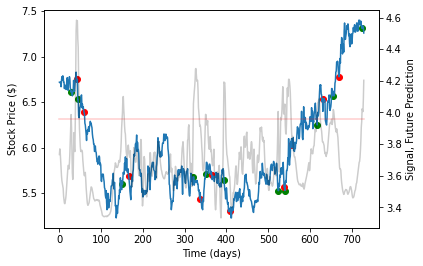

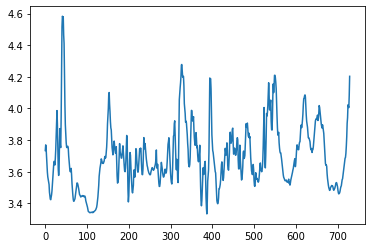

3.750150528104991


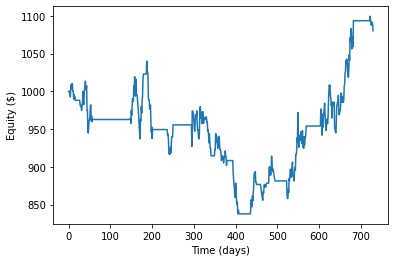

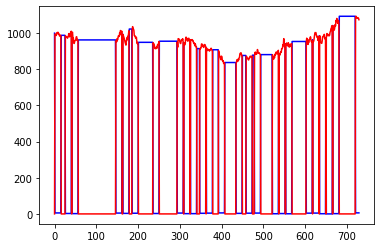

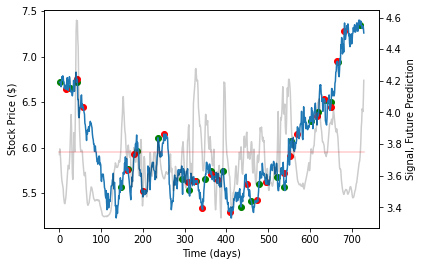

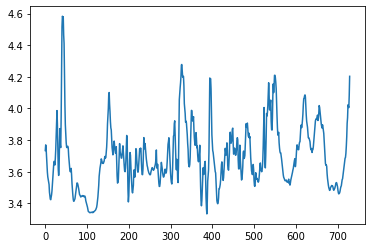

3.541991948466518


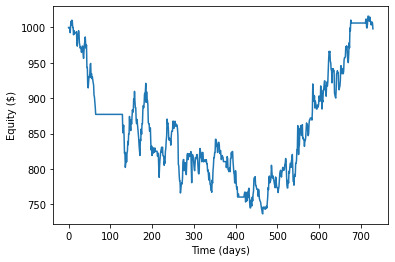

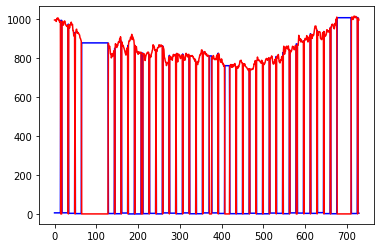

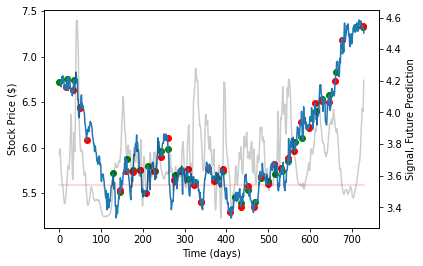

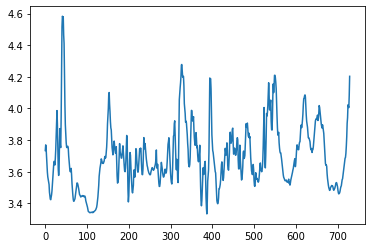

3.3338333688280453


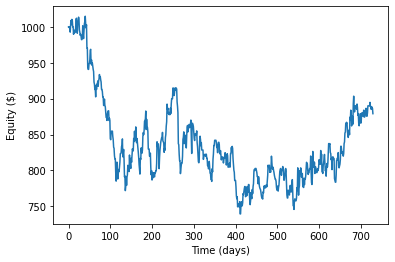

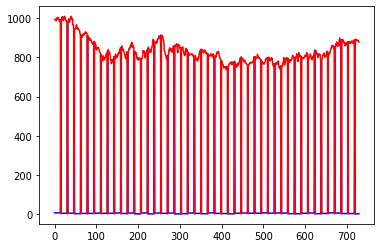

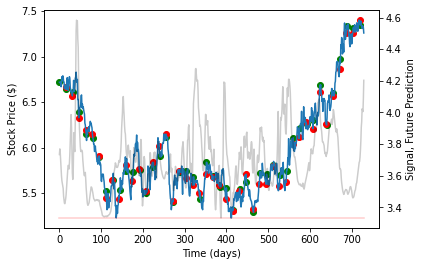

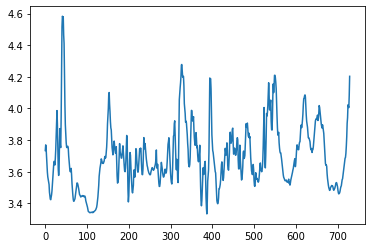

In [476]:
for threshold in thresholdRange(subTimeSeries, 6)[::-1]:
    print(threshold)
    trackModel(threshold)

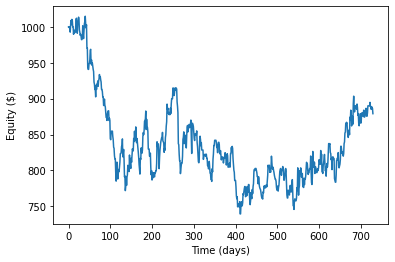

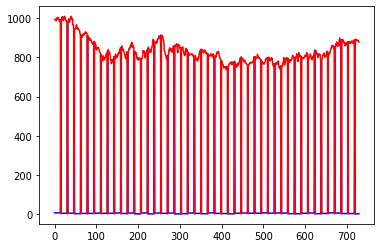

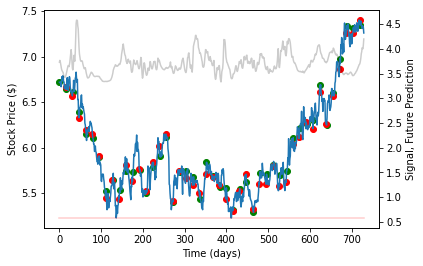

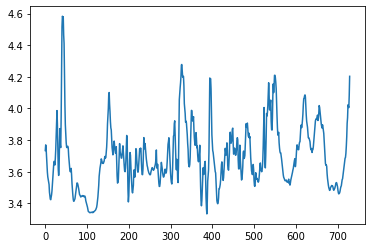

In [477]:
trackModel(0.58)

3.3338333688280453
4.582784846658881


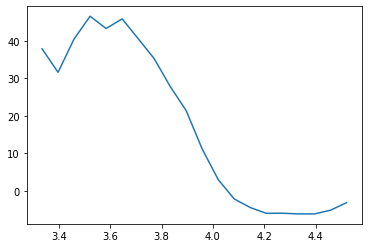

In [478]:
def effectivity(threshold):
    buys = []
    sells = []
    stockPrices = []
    signals = []
    profits = []

    for i in range(len(subTimeSeries) - lastPredictionAdj):
        stockPrice = subTimeSeries[i][-1]
        stockPriceFuture = subTimeSeries[i+lastPredictionAdj][-1]
        signal = shoudlBuyorSell(subTimeSeries[i])

        buys.append(None)
        sells.append(None)
        stockPrices.append(stockPrice)
        signals.append(signal)
        profits.append(0)
        if(signal > threshold):
            #buy
            buys[i] = stockPrice  
            profit = stockPriceFuture - stockPrice
            profits[i] = profit


    return np.sum(profits)


profits = []
thresholds = []
for threshold in thresholdRange(subTimeSeries, 20)[::-1]:
    profits.append(effectivity(threshold))
    thresholds.append(threshold)

plt.plot(thresholds, profits)
plt.show()